# Support Vector Machines
<br>
In this tutorial, we will explore the last supervised classification algorithm of the course - **Support Vector Machines**. The first half of the assignment will introduce the major components of SVMs whereas the second half of the assignment will an application of SVMs for spam email classification (covered in the next blog post). Let's get started!

Our first dataset has two features and is linearly separatible, so let's start by visualizing it in a plot.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

ex1Data = scipy.io.loadmat("ex6data1.mat")
ex1_X = ex1Data["X"]
ex1_y = ex1Data["y"]
# convert ex1_y to be 1-D list
ex1_y = ex1_y[:,0]

ex1_df = pd.DataFrame({"x1": ex1_X[:,0], "x2": ex1_X[:,1], "y": ex1_y})
ex1_df.head()

,x1,x2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


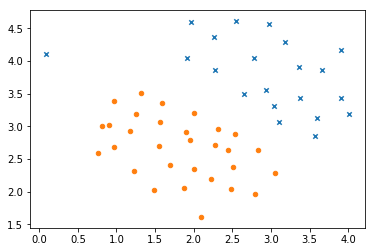

In [5]:
def plotData(df):
    x1 = df["x1"]
    x2 = df["x2"]
    y = df["y"]
    
    pos = df[df["y"] == 1]
    neg = df[df["y"] == 0]
    
    plt.scatter(pos["x1"],pos["x2"],marker="x",s=20, label="pos")
    plt.scatter(neg["x1"],neg["x2"],marker="o",s=20, label="neg")
    return

plotData(ex1_df)
plt.show()

An SVM is known as a *large margin classifier*. This is because the SVM algorithm tries to separate classes with as wide as a margin distance as possible.

<img src="./lmc.png" style="width: 300px;"/>

For the example above, there are many ways to separate the two classes, such as the magenta and green lines. However those lines don't seem "natural", so the SVM algorithm will produce a line with maximum margin distance to the closest two data points. This is denoted by the black line, which has large margin distances denoted in blue.

An important parameter we'll see later for a SVM classifier is **C**. The *C* parameter functions similarly to the $\lambda$ parameter for regularization in the previous algorithms we covered. But the difference is that high values of *C* are more likely to cause overfitting, which contrasts to this occuring with low values of $\lambda$. Likewise low *C* values is more likely to cause underfitting, whereas this occurs with high values of $\lambda$.

If we wanted to be even more specific, an SVM with a high C valuewill choose a classifier that *classifies as many points correctly* as possible even if it has to choose a *very small margin classifier* to do so (hence the likeliness of overfitting). A classifer with a low C value will choose a *large margin classifier* even if some data points are misclassified. 

We will explore this by building an SVM using Scikit-learn with C = 1 and another SVM with C = 100:

In [6]:
from sklearn import svm

linear_svc_c1 = svm.SVC(C=1, kernel="linear") # SVC means support vector classifier
linear_svc_c1.fit(ex1_X, ex1_y)
print(linear_svc_c1.intercept_, linear_svc_c1.coef_)

[-10.34889778] [[ 1.40718563  2.13398052]]


Above we trained a linear SVC with $C=1$. The returned fitted $\theta$ parameters are:


\begin{align}
\theta_0 &= -10.34889778 \\
\theta_1 &= 1.40718563 \\
\theta_2 &= 2.13398052 \\
\end{align}

Note that the SVM hypothesis function is:
$$
h_{\theta}(x) =
\begin{cases}
    1 & \text{if } \theta^Tx \ge 0\\
    0              & \text{otherwise}
\end{cases}
$$

Therefore the equation for the decision boundary is:

$$0 = \theta_0x_0 + \theta_1x_1 + \theta_2x_2$$

Rearranging in terms of $x_2$ to get a line:

$$x_2 = \frac{-(\theta_0 + \theta_1x_1)}{\theta_2}~~(remember~ x_0=1) $$

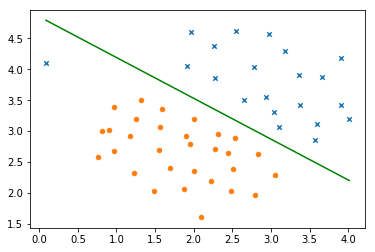

In [7]:
def visualizeBoundaryLinear(model):
    global ex1_df
    
    theta_0 = model.intercept_[0]
    theta_1 = model.coef_[0,0]
    theta_2 = model.coef_[0,1]
    x1 = ex1_df["x1"]
    
    xRange = np.linspace(x1.min(), x1.max(), 100)
    decisionBoundary = -(theta_0 + theta_1*xRange) / theta_2
    
    # plotting
    plotData(ex1_df)
    plt.plot(xRange, decisionBoundary, color="g")
    plt.show()
    return

visualizeBoundaryLinear(linear_svc_c1)

Note that for a low *C* value, the *x* outlier on the far left side is misclassified in turn for a larger margin decision boundary.

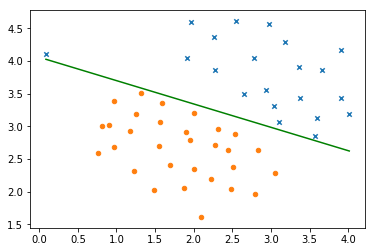

In [8]:
linear_svc_c100 = svm.SVC(C=100, kernel="linear")
linear_svc_c100.fit(ex1_X, ex1_y)

visualizeBoundaryLinear(linear_svc_c100)

Conversely for *C* = 100, all the points are classified correctly but the tradeoff is a less "natural", smaller margin classifier for the data set. 

So that was it for the first dataset, let's move onto the next dataset of the assignment.

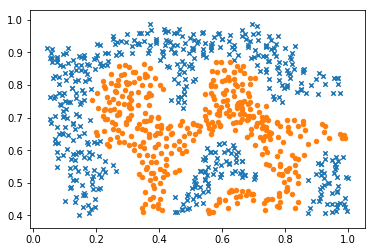

In [7]:
ex2Data = scipy.io.loadmat("ex6data2.mat")
ex2_X = ex2Data["X"]
ex2_y = ex2Data["y"]
# convert ex1_y to be 1-D list
ex2_y = ex2_y[:,0]

ex2_df = pd.DataFrame({"x1": ex2_X[:,0], "x2": ex2_X[:,1], "y": ex2_y})
plotData(ex2_df)
plt.show()

This example clearly shows that the data is not linearly separatible, so we will use **kernels** to help come up with some complex decision boundaries. You can think of a kernel as a "similarity" function. The kernel type we will use for this assignment is called the **Gaussian kernel** and it is represented by the following equation:

$$
kernel(x^{(1)},x^{(2)}) = similarity(x^{(1)},x^{(2)}) = exp{(-\frac{\lVert x^{(1)}-x^{(2)} \rVert^2}{2\sigma^2})} \\
where~~\lVert x^{(1)}-x^{(2)} \rVert^2 = \sum_{j=1}^n (x_j^{(1)} - x_j^{(2)})^2
$$

Recall that $\lVert x^{(1)}-x^{(2)} \rVert^2$ is the (Euclidean distance)$^2$ between $x^{(1)}$ and $x^{(2)}$. So if two points $x^{(1)}, x^{(2)}$ are very "similar", then their Euclidean distance = $\lVert x^{(1)}-x^{(2)} \rVert^2 \approx 0$ and the Gaussian kernel $\approx 1$ since $e^0$ = 1. Similarly if two points are not "similar" then their Gaussian kernel $\approx 0.$ Let's see the Gaussian kernel function in action:

In [16]:
def gaussianKernel(x1,x2,sigma):
    norm_sq = np.sum(np.square(x1 - x2))
    sim = np.exp(-norm_sq/(2*sigma**2))
    return sim

x1 = np.array([1,2,1])
x2 = np.array([0,4,-1])
sigma = 2
similarity1 = gaussianKernel(x1,x2,sigma)
print("similarity between ", x1, ",", x2, " =", similarity1)

x3 = np.array([1,2,0.9])
similarity2 = gaussianKernel(x1,x3,sigma)
print("similarity between ", x1, ",", x3, " =", similarity2)

similarity between  [1 2 1] , [ 0  4 -1]  = 0.324652467358
similarity between  [1 2 1] , [ 1.   2.   0.9]  = 0.998750780925


You might be asking what $sigma$ is in the Gaussian kernel. The $\sigma$ parameter is a measure of how *smooth* the kernel function is. For example, let's say the distance$^2$ between two points *L* and *$x_1$* is 1. If $\sigma$ is very large, then:

$$exp{(-\frac{\lVert L-x_1 \rVert^2}{2\sigma^2})} = exp{(-\frac{1}{large~number})} \approx exp{(-0)} \approx 1$$.

and points *L* and *$x_1$* are considered similar. Conversely for a small $\sigma$:

$$exp{(-\frac{\lVert L-x_1 \rVert^2}{2\sigma^2})} = exp{(-\frac{1}{small~number})} \approx exp{(-large~number)} \approx 0$$.

and points *L* and $x_1$ are not considered similar. 

Thus for large $\sigma$, the kernel function is smooth:

<img src="./smooth.png" style="width: 150px;"/>

since a small change in distance from point *L* would not change "similarity" as much. But for small $\sigma$, the kernel function is not smooth:

<img src="./sharp.png" style="width: 150px;"/>

since a change in distance from point *L* would change "similarity" dramatically.

Consequently, a large $\sigma$ is associated with **underfitting** whereas a small $\sigma$ is associated with **overfitting**.

Now let's create an SVM using a Gaussian kernel. In scikit-learn, the Gaussian kernel is called the **radial basis function** but its equation  in sklearn is defined as

$$K(\mathbf {x} ,\mathbf {x'} )=\exp(-\gamma \|\mathbf {x} -\mathbf {x'} \|^{2})$$

so we will have to manually set $\gamma = \frac{1}{2\sigma^2}$. 

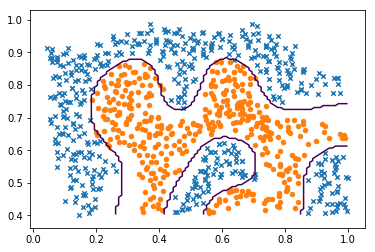

In [17]:
sigma = 0.1
C = 1
gamma = 1/(2*sigma**2)
clf = svm.SVC(C=C,kernel="rbf",gamma=gamma)
clf.fit(ex2_X, ex2_y)

# visualizing plot

def visualizeBoundary(df, model):
    x1Range = np.linspace(df["x1"].min(), df["x1"].max(), 100)
    x2Range = np.linspace(df["x2"].min(), df["x2"].max(), 100)
    X,Y = np.meshgrid(x1Range, x2Range)
    coordinates = np.c_[X.ravel(), Y.ravel()]
    Z = model.predict(coordinates)
    Z = Z.reshape(X.shape)
    plotData(df)
    plt.contour(X,Y,Z,[0.5])
    plt.show()
    
visualizeBoundary(ex2_df, clf)

As you can see the SVM created a complex decision boundary using the Gaussian similarity measure. Any point in the "inner" boundary are classified as similar to the orange points whereas points in the "outside" boundary are classified to be similar to the blue crosses.

Let's now look at the final part of this post. We will again build an SVM using a Gaussian kernel:

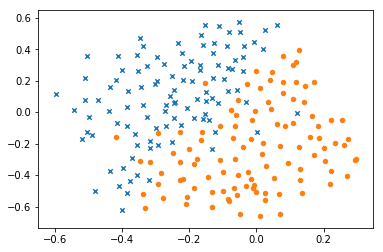

In [19]:
ex3Data = scipy.io.loadmat("ex6data3.mat")
ex3_X = ex3Data["X"]
ex3_Xval = ex3Data["Xval"]
ex3_y = ex3Data["y"]
ex3_yval = ex3Data["yval"]

# convert ex1_y, ex1_yval to be 1-D list
ex3_y = ex3_y[:,0]
ex3_yval = ex3_yval[:,0]

ex3_df = pd.DataFrame({"x1": ex3_X[:,0], "x2": ex3_X[:,1], "y": ex3_y})
ex3_df_val = pd.DataFrame({"x1": ex3_Xval[:,0], "x2": ex3_Xval[:,1], "y": ex3_yval})
plotData(ex3_df)
plt.show()

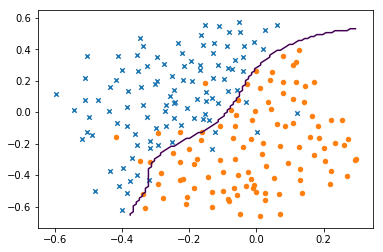

In [20]:
sigma = 0.1
C = 0.3
gamma = 1/(2*sigma**2)
clf = svm.SVC(C=C,kernel="rbf",gamma=gamma)
clf.fit(ex3_X, ex3_y)

visualizeBoundary(ex3_df, clf)

The classifier above looks good but how about we and mix and match different C and $\sigma$ parameters to see if we can get even better performance on the classifier. To do so, we will loop through different combinations of (C, $\sigma$) pairs and train and evaluate the performance of an SVM for each pair.

Minimum error is 0.035 for [C,sigma] = [ 1.   0.1]


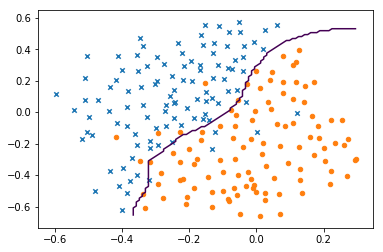

In [21]:
C_vec = [0.01,0.03,0.1,0.3,1,3,10,30]
sigma_vec = [0.01,0.03,0.1,0.3,1,3,10,30]

def bestParams(X, y, Xval, yval, C_vec, sigma_vec):
    
    CC, ss = np.meshgrid(C_vec, sigma_vec)
    C_sigma_pairs = np.c_[CC.ravel(),ss.ravel()] # [[C, sigma]*]
    minError = 1
    bestPair = ()
    bestClf = None

    for pair in C_sigma_pairs:
        C = pair[0]
        sigma = pair[1]
        gamma = 1/(2*sigma**2)
        clf = svm.SVC(C=C, kernel="rbf", gamma=gamma)
        clf.fit(X,y)
        
        # predict using validation set and compute error
        predictions = clf.predict(Xval)
        predictions = predictions.ravel() # flatten to 1-D array
        logicalColumn = predictions != yval
        logicalColumn = logicalColumn.astype(int)
        
        pairError = sum(logicalColumn) / len(logicalColumn) 
        # fraction of points classified incorrectly
            
        if pairError < minError:
            minError = pairError
            bestPair = pair
            bestClf = clf
    
    return minError, bestPair, bestClf

minError, bestPair, bestClf = bestParams(ex3_X, ex3_y, ex3_Xval, ex3_yval, C_vec, sigma_vec)
print("Minimum error is", minError, "for [C,sigma] =", bestPair)

visualizeBoundary(ex3_df, bestClf)

Congrats for making it past the first half of the SVM assignment! By now you should have a better understanding of how an SVM works, what a kernel is, and a basic way to tune SVM parameters for better performance. In the next tutorial post, we will look at the second half of the assignment which is making your own spam email classifier using SVMs. See you there! :)